In [111]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
from dateutil.parser import parse
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [112]:
plot_summaries = pd.read_csv('./data/plot_summaries.txt', sep='\t', header=None)
plot_summaries.rename(columns={
    0: 'movie_id',
    1: 'plot_summary'
}, inplace=True)
plot_summaries

,movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [113]:
plot_summaries.plot_summary[0]

"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

In [114]:
# Import character metadata
char_metadata = pd.read_csv('./data/character.metadata.tsv', sep='\t', header=None)
char_metadata.rename(columns={
    0:'movie_id',
    1:'freebase_movie_id',
    2:'release_date',
    3:'char',
    4:'actor_birth_date',
    5:'actor_gender',
    6:'actor_height', #in meters
    7:'freebase_actor_ethnicity',
    8:'actor',
    9:'actor_age_at_movie_release',
    10:'freebase_char_actor_map_id',
    11:'freebase_char_id',
    12:'freebase_actor_id'
}, inplace=True)

# Correct errors where a height of 1.78m appears as 510 (5ft10in)
ft_510_error = char_metadata[char_metadata['actor_height'] == 510.0]
char_metadata.loc[ft_510_error.index, ['actor_height']] = 1.78
# Correct errors where height is in cm rather than m
cm_error = char_metadata[char_metadata['actor_height'] > 10]
char_metadata.loc[cm_error.index, ['actor_height']] /= 100

# Datetime conversions (NB:very computationally expensive)
char_metadata.release_date = pd.to_datetime(char_metadata.release_date, errors='coerce')
char_metadata.actor_birth_date = pd.to_datetime(char_metadata.actor_birth_date, errors='coerce')

# Remove  unused freebase IDs
char_metadata = char_metadata.drop(['freebase_movie_id', 'freebase_char_id', 'freebase_actor_id'], axis=1)

#Remove redundant actor age at release
char_metadata = char_metadata.drop(['actor_age_at_movie_release'], axis=1)

char_metadata = char_metadata.set_index(['movie_id', 'freebase_char_actor_map_id'])
char_metadata

release_date                        char  \
movie_id freebase_char_actor_map_id                                            
975900   /m/0bgchxw                   2001-08-24                    Akooshay   
         /m/0jys3m                    2001-08-24  Lieutenant Melanie Ballard   
         /m/0jys3g                    2001-08-24         Desolation Williams   
         /m/02vchl6                   2001-08-24          Sgt Jericho Butler   
         /m/02vbb3r                   2001-08-24             Bashira Kincaid   
...                                          ...                         ...   
913762   /m/0kr406c                   1992-05-21                      Elensh   
         /m/0kr405_                   1992-05-21                      Hibiki   
28308153 /m/0g8ngmc                   1957-01-01                         NaN   
         /m/0g8ngmj                   1957-01-01                         NaN   
         /m/0g8ngmw                   1957-01-01                         NaN   

                                        actor_birth_date actor_gender  \
movie_id freebase_char_actor_map_id                                     
975900   /m/0bgchxw                  1958-08-26 00:00:00            F   
         /m/0jys3m                   1974-08-15 00:00:00            F   
         /m/0jys3g                   1969-06-15 00:00:00            M   
         /m/02vchl6                  1967-09-12 00:00:00            M   
         /m/02vbb3r                  1977-09-25 00:00:00            F   
...                                                  ...          ...   
913762   /m/0kr406c                  1970-05-01 00:00:00            F   
         /m/0kr405_                  1965-04-12 00:00:00            M   
28308153 /m/0g8ngmc                  1941-11-18 00:00:00            M   
         /m/0g8ngmj                                  NaN          NaN   
         /m/0g8ngmw                                  NaN          NaN   

                                     actor_height freebase_actor_ethnicity  \
movie_id freebase_char_actor_map_id                                          
975900   /m/0bgchxw                         1.620                      NaN   
         /m/0jys3m                          1.780               /m/044038p   
         /m/0jys3g                          1.727                  /m/0x67   
         /m/02vchl6                         1.750                      NaN   
         /m/02vbb3r                         1.650                      NaN   
...                                           ...                      ...   
913762   /m/0kr406c                           NaN                      NaN   
         /m/0kr405_                           NaN                      NaN   
28308153 /m/0g8ngmc                         1.730                /m/02w7gg   
         /m/0g8ngmj                           NaN                      NaN   
         /m/0g8ngmw                           NaN                      NaN   

                                                  actor  
movie_id freebase_char_actor_map_id                      
975900   /m/0bgchxw                      Wanda De Jesus  
         /m/0jys3m                   Natasha Henstridge  
         /m/0jys3g                             Ice Cube  
         /m/02vchl6                       Jason Statham  
         /m/02vbb3r                         Clea DuVall  
...                                                 ...  
913762   /m/0kr406c                  Dorothy Elias-Fahn  
         /m/0kr405_                       Jonathan Fahn  
28308153 /m/0g8ngmc                      David Hemmings  
         /m/0g8ngmj                    Roberta Paterson  
         /m/0g8ngmw                         John Rogers  

[450669 rows x 7 columns]

In [115]:
dates = char_metadata.reset_index().drop_duplicates(subset = "movie_id")[["movie_id", "release_date"]].set_index('movie_id')
dates

,release_date
movie_id,
975900,2001-08-24
3196793,2000-02-16
28463795,1988-01-01
261236,1983-01-01
2238856,2005-01-01
...,...
7223293,1925-01-01
9971909,1972-09-22
12476867,2002-01-01


In [116]:
def extract_values(s):
    s = s.split(',')
    for i in range(len(s)):
        s[i] = s[i][s[i].find('": "')+len('": "'):]
        s[i] = s[i][:s[i].find('"')]
    s.sort()
    return ','.join(s)

# Import movie metadata
movie_metadata = pd.read_csv('./data/movie.metadata.tsv', sep='\t', header=None)
movie_metadata.rename(columns={
    0:'movie_id',
    1:'freebase_movie_id',
    2:'movie_name',
    3:'release_date',
    4:'box_office_revenue',
    5:'runtime',
    6:'freebase_languages',
    7:'freebase_countries',
    8:'freebase_genres'
}, inplace=True)

# Remove Freebase IDs
# movie_metadata = movie_metadata[movie_metadata.columns.drop(list(movie_metadata.filter(regex='freebase')))]

# Datetime conversions
movie_metadata.release_date = pd.to_datetime(movie_metadata.release_date, errors='coerce')
movie_metadata = movie_metadata.drop('freebase_movie_id', axis=1)
movie_metadata = movie_metadata.set_index('movie_id')

# Dict data extraction
movie_metadata.freebase_languages = movie_metadata.freebase_languages.apply(extract_values)
print("lang", len(movie_metadata.freebase_languages.unique()), movie_metadata.shape[0])
movie_metadata.freebase_countries = movie_metadata.freebase_countries.apply(extract_values)
print("conuntries", len(movie_metadata.freebase_countries.unique()), movie_metadata.shape[0])
movie_metadata.freebase_genres = movie_metadata.freebase_genres.apply(extract_values)
print("genres", len(movie_metadata.freebase_genres.unique()), movie_metadata.shape[0])

# Drop duplicate columns for merging
movie_metadata = movie_metadata.drop(['release_date'], axis=1)


movie_metadata

lang 1667 81741
conuntries 2021 81741
genres 22507 81741


,movie_name,box_office_revenue,runtime,freebase_languages,freebase_countries,freebase_genres
movie_id,,,,,,
975900,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Action,Adventure,Horror,Science Fiction,Space ..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Biographical film,Crime Drama,Drama,Mystery"
28463795,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama"
9363483,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Erotic thriller,Psychological thriller,Thriller"
261236,A Woman in Flames,NaN,106.0,German Language,Germany,Drama
...,...,...,...,...,...,...
35228177,Mermaids: The Body Found,NaN,120.0,English Language,United States of America,Drama
34980460,Knuckle,NaN,96.0,English Language,"Ireland,United Kingdom","Biographical film,Documentary,Drama"
9971909,Another Nice Mess,NaN,66.0,English Language,United States of America,"Comedy,Satire"


In [117]:
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81741 entries, 975900 to 12476867
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_name          81741 non-null  object 
 1   box_office_revenue  8401 non-null   float64
 2   runtime             61291 non-null  float64
 3   freebase_languages  81741 non-null  object 
 4   freebase_countries  81741 non-null  object 
 5   freebase_genres     81741 non-null  object 
dtypes: float64(2), object(4)
memory usage: 4.4+ MB


In [118]:
movie_metadata.describe()

,box_office_revenue,runtime
count,8.401000e+03,6.129100e+04
mean,4.799363e+07,1.118192e+02
std,1.121753e+08,4.360070e+03
min,1.000000e+04,0.000000e+00
25%,2.083193e+06,8.100000e+01
50%,1.063969e+07,9.300000e+01
75%,4.071696e+07,1.060000e+02
max,2.782275e+09,1.079281e+06


In [119]:
tvtropes_clusters = pd.read_csv('./data/tvtropes.clusters.txt', sep='\t', header=None)

tvtropes_clusters.rename(columns={
    0: 'char_trope',
    1: 'attr'
}, inplace=True)
clust = tvtropes_clusters.attr.apply(lambda x: pd.Series(ast.literal_eval(x)))
tvtropes_clusters = pd.concat([tvtropes_clusters, clust], axis=1).drop('attr', axis = 1)
tvtropes_clusters.rename(columns={
    'id': 'freebase_char_actor_map_id'
}, inplace=True)

tvtropes_clusters = tvtropes_clusters.set_index(['char_trope', 'freebase_char_actor_map_id'])

# Drop duplicate columns for merging
tvtropes_clusters = tvtropes_clusters.drop(['char', 'actor', 'movie'], axis = 1)

tvtropes_clusters

Empty DataFrame
Columns: []
Index: [(absent_minded_professor, /m/0jy9q0), (absent_minded_professor, /m/02vchl3), (absent_minded_professor, /m/0k6fkc), (absent_minded_professor, /m/0k6_br), (absent_minded_professor, /m/0k3rhh), (adventurer_archaeologist, /m/0jzx78), (adventurer_archaeologist, /m/0k294p), (adventurer_archaeologist, /m/0jzx9b), (adventurer_archaeologist, /m/0k5yzc), (arrogant_kungfu_guy, /m/02vd8hn), (arrogant_kungfu_guy, /m/0k5jyf), (arrogant_kungfu_guy, /m/0jwv09), (arrogant_kungfu_guy, /m/0gz3h92), (arrogant_kungfu_guy, /m/0k2n0d), (arrogant_kungfu_guy, /m/0k2n56), (arrogant_kungfu_guy, /m/052dfd5), (arrogant_kungfu_guy, /m/02214xq), (arrogant_kungfu_guy, /m/02sg5ry), (big_man_on_campus, /m/02vbkvz), (big_man_on_campus, /m/0j_6gm), (big_man_on_campus, /m/02vc983), (big_man_on_campus, /m/0k14rv), (big_man_on_campus, /m/02vdf9d), (big_man_on_campus, /m/0jzdys), (big_man_on_campus, /m/03jsnmf), (bounty_hunter, /m/0jybsq), (bounty_hunter, /m/0k61jr), (bounty_hunter, /m/06wh7_d), (bounty_hunter, /m/0k6bqx), (bounty_hunter, /m/0jvhbm), (bounty_hunter, /m/02vbtgt), (bounty_hunter, /m/0k0n9r), (bounty_hunter, /m/0772tb3), (bounty_hunter, /m/0k4qdz), (bounty_hunter, /m/03jsm0f), (brainless_beauty, /m/04dddz5), (brainless_beauty, /m/02tbdw7), (brainless_beauty, /m/02vdf9d), (brainless_beauty, /m/04dgw4t), (brainless_beauty, /m/03lvf22), (brainless_beauty, /m/0gc3g1p), (brainless_beauty, /m/0k4k_5), (brainless_beauty, /m/0k2q15), (brainless_beauty, /m/0jvy0r), (brainless_beauty, /m/0b3trzf), (brainless_beauty, /m/0cg2m9s), (brainless_beauty, /m/0jzvtp), (broken_bird, /m/0j_wlm), (broken_bird, /m/04q4dng), (broken_bird, /m/0jwrqb), (broken_bird, /m/02tbbww), (broken_bird, /m/0cccx3m), (bromantic_foil, /m/0jwj18), (bromantic_foil, /m/09vvrb_), (bromantic_foil, /m/07ldy8x), (bromantic_foil, /m/05ckj7h), (bromantic_foil, /m/0k35nb), (bruiser_with_a_soft_center, /m/0jzb66), (bruiser_with_a_soft_center, /m/0hcfdd1), (bruiser_with_a_soft_center, /m/02hw79s), (bully, /m/0jty60), (bully, /m/0jsprx), (bully, /m/0k592n), (byronic_hero, /m/0k28_g), (byronic_hero, /m/02hw79s), (byronic_hero, /m/0k43s9), (byronic_hero, /m/02sg5ry), (byronic_hero, /m/0jz0wk), (byronic_hero, /m/02vczvr), (byronic_hero, /m/0667g_f), (byronic_hero, /m/0k7ckp), (byronic_hero, /m/0h5m_9x), (byronic_hero, /m/0jxftx), (byronic_hero, /m/0k1xxm), (byronic_hero, /m/0k5ptk), (byronic_hero, /m/0k65k8), (byronic_hero, /m/0j1__hv), (byronic_hero, /m/0855mjk), (byronic_hero, /m/0k3tt_), (byronic_hero, /m/0jynbm), (casanova, /m/0jw4mw), (casanova, /m/0j_flm), (casanova, /m/0j1__hv), (casanova, /m/0dkcy1f), (casanova, /m/0k5ptk), (casanova, /m/02vch3p), (casanova, /m/0cf_wtd), (chanteuse, /m/02wszk9), (chanteuse, /m/0k5wls), (chanteuse, /m/0k50tl), (chanteuse, /m/0k3j8v), (chanteuse, /m/0jvlc4), (chanteuse, /m/0k3w12), (charmer, /m/02hw79s), (charmer, /m/0k3r1_), (charmer, /m/0k1xxm), (charmer, /m/0jw5pq), (charmer, /m/04hv61w), (charmer, /m/07sl05m), (charmer, /m/0k6g86), ...]

[501 rows x 0 columns]

In [120]:
name_clusters = pd.read_csv('./data/name.clusters.txt', sep='\t', header=None)
name_clusters.rename(columns={
    0: 'char',
    1: 'freebase_char_actor_map_id'
}, inplace=True)
name_clusters

,char,freebase_char_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
...,...,...
2661,John Rolfe,/m/0k5_ql
2662,John Rolfe,/m/02vd6vs
2663,Elizabeth Swann,/m/0k1xvz
2664,Elizabeth Swann,/m/0k1x_d


In [121]:
combined_data = pd.merge(movie_metadata, char_metadata, left_index=True, right_index=True)
tvtropes_data = pd.merge(combined_data, tvtropes_clusters, left_index=True, right_index=True)

combined_data = combined_data.reset_index()
combined_data = combined_data.drop(['movie_id', 'freebase_char_actor_map_id'], axis = 1)
combined_data = combined_data.set_index(['movie_name', 'char'])

tvtropes_data = tvtropes_data.reset_index()
tvtropes_data = tvtropes_data.drop(['movie_id', 'freebase_char_actor_map_id'], axis = 1)

In [122]:
combined_data_ordered = combined_data.reset_index().set_index(
    ["movie_name", "box_office_revenue",
     "runtime", "freebase_genres", "freebase_languages",
     "freebase_countries", "release_date", "char"]
    )[["actor", "actor_gender", "actor_gender", "actor_birth_date", "freebase_actor_ethnicity"]]
combined_data_ordered

actor  \
movie_name                                         box_office_revenue runtime freebase_genres                                    freebase_languages freebase_countries       release_date char                                             
Ghosts of Mars                                     14010832.0         98.0    Action,Adventure,Horror,Science Fiction,Space w... English Language   United States of America 2001-08-24   Akooshay                        Wanda De Jesus   
                                                                                                                                                                                          Lieutenant Melanie Ballard  Natasha Henstridge   
                                                                                                                                                                                          Desolation Williams                   Ice Cube   
                                                                                                                                                                                          Sgt Jericho Butler               Jason Statham   
                                                                                                                                                                                          Bashira Kincaid                    Clea DuVall   
...                                                                                                                                                                                                                                  ...   
The Super Dimension Fortress Macross II: Lovers... NaN                150.0   Adventure,Animation,Anime,Drama,Japanese Movies... Japanese Language  Japan                    1992-05-21   Elensh                      Dorothy Elias-Fahn   
                                                                                                                                                                                          Hibiki                           Jonathan Fahn   
Five Clues to Fortune                              NaN                129.0   Crime Fiction                                      English Language   United Kingdom           1957-01-01   NaN                             David Hemmings   
                                                                                                                                                                                          NaN                           Roberta Paterson   
                                                                                                                                                                                          NaN                                John Rogers   

                                                                                                                                                                                                                     actor_gender  \
movie_name                                         box_office_revenue runtime freebase_genres                                    freebase_languages freebase_countries       release_date char                                      
Ghosts of Mars                                     14010832.0         98.0    Action,Adventure,Horror,Science Fiction,Space w... English Language   United States of America 2001-08-24   Akooshay                              F   
                                                                                                                                                                                          Lieutenant Melanie Ballard            F   
                                                                                                                                                                                          Desolation Williams                   M   
             

In [123]:
combined_data_ordered.loc["Ghosts of Mars"]

actor  \
box_office_revenue runtime freebase_genres                                    freebase_languages freebase_countries       release_date char                                             
14010832.0         98.0    Action,Adventure,Horror,Science Fiction,Space w... English Language   United States of America 2001-08-24   Akooshay                        Wanda De Jesus   
                                                                                                                                       Lieutenant Melanie Ballard  Natasha Henstridge   
                                                                                                                                       Desolation Williams                   Ice Cube   
                                                                                                                                       Sgt Jericho Butler               Jason Statham   
                                                                                                                                       Bashira Kincaid                    Clea DuVall   
                                                                                                                                       Commander Helena Braddock            Pam Grier   
                                                                                                                                       Whitlock                        Joanna Cassidy   
                                                                                                                                       Big Daddy Mars                 Richard Cetrone   
                                                                                                                                       Michael Descanso                    Liam Waite   
                                                                                                                                       Uno                                Duane Davis   
                                                                                                                                       Dos                             Lobo Sebastian   
                                                                                                                                       Tres                           Rodney A. Grant   
                                                                                                                                       McSimms                            Peter Jason   
                                                                                                                                       Zimmerman                       Rick Edelstein   
                                                                                                                                       Benchley                          Doug McGrath   
                                                                                                                                       Rodale                        Robert Carradine   
                                                                                                                                       NaN                           Rosemary Forsyth   

                                                                                                                                                                  actor_gender  \
box_office_revenue runtime freebase_genres                                    freebase_languages freebase_countries       release_date char                                      
14010832.0         98.0    Action,Adventure,Horror,Science Fiction,Space w... English Language   United States of America 2001-08-24   Akooshay                              F   
                                                                                                                              

# Visualizations & Exploration

<h2>General Description</h2>

In [124]:
combined_data.describe()

,box_office_revenue,runtime,actor_height
count,1.010280e+05,4.001990e+05,154824.000000
mean,6.940705e+07,1.288516e+02,1.748181
std,1.469544e+08,5.394664e+03,0.106245
min,1.000000e+04,0.000000e+00,0.610000
25%,3.600000e+06,8.800000e+01,1.676400
50%,1.784087e+07,9.700000e+01,1.750000
75%,6.684503e+07,1.120000e+02,1.830000
max,2.782275e+09,1.079281e+06,2.356000


<h2>Box Office Revenue</h2>

In [125]:
char_metadata.reset_index()

,movie_id,freebase_char_actor_map_id,release_date,char,actor_birth_date,actor_gender,actor_height,freebase_actor_ethnicity,actor
0,975900,/m/0bgchxw,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus
1,975900,/m/0jys3m,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge
2,975900,/m/0jys3g,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube
3,975900,/m/02vchl6,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham
4,975900,/m/02vbb3r,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall
...,...,...,...,...,...,...,...,...,...
450664,913762,/m/0kr406c,1992-05-21,Elensh,1970-05-01 00:00:00,F,NaN,NaN,Dorothy Elias-Fahn
450665,913762,/m/0kr405_,1992-05-21,Hibiki,1965-04-12 00:00:00,M,NaN,NaN,Jonathan Fahn
450666,28308153,/m/0g8ngmc,1957-01-01,NaN,1941-11-18 00:00:00,M,1.730,/m/02w7gg,David Hemmings
450667,28308153,/m/0g8ngmj,1957-01-01,NaN,NaN,NaN,NaN,NaN,Roberta Paterson


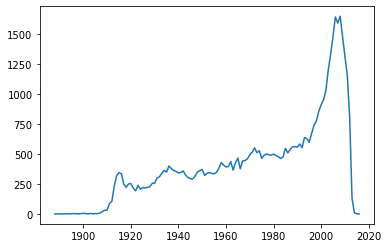

In [126]:
date_metadata = pd.merge(dates, movie_metadata, left_index=True, right_index = True)
date_metadata["release_year"] = date_metadata.release_date.apply(lambda x: x.year)
na_revenue_per_year = date_metadata.reset_index()[["release_year", "box_office_revenue"]].groupby("release_year").apply(lambda x: x.box_office_revenue.isna().sum())
plt.plot(na_revenue_per_year.index, na_revenue_per_year.values)
plt.show()

In [127]:
print(f"Revenue NA presence: {date_metadata.box_office_revenue.isna().sum() / date_metadata.shape[0] * 100 :.2f}%")

Revenue NA presence: 87.22%


d:\ProgramFiles\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


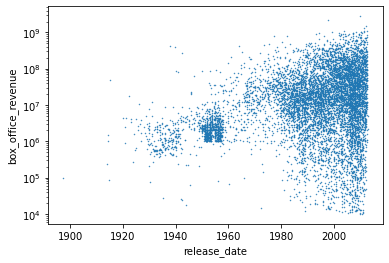

In [128]:
date_metadata.plot.scatter(x='release_date', y='box_office_revenue', logy=True, s=0.2)
plt.show()

High NA presence in box office revenue more recently, but also much higher amount of produced movies...

<h2>Runtime</h2>

Outlier observed in runtime. Max value is way too long for a movie.

Display outlier movies

In [129]:
movie_metadata[movie_metadata.runtime >= movie_metadata.runtime.quantile(0.9999)].reset_index().set_index('movie_name')['runtime']

movie_name
Zero Tolerance           1079281.00
Paradise in Harlem          5100.00
Matrjoschka                 5700.00
Kai Koduttha Dheivam        4875.27
The Cure for Insomnia       5220.00
Modern Times Forever       14400.00
Cinématon                   9360.00
Name: runtime, dtype: float64

Either via manual investigation + correction or outlier filter. If this feature is even going to be analyzed. [At least Zero Tolerance does not have that runtime](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi144Xr0pz7AhUK_rsIHbffDuYQFnoECAwQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FZero_Tolerance_(1995_film)&usg=AOvVaw3yaZGTK0e4txGAfZ_n7UdV)

<h2>Genre</h2>

In [130]:
genres = combined_data.freebase_genres.unique()

print(f"Unique genre combinations: {len(genres)}")

Unique genre combinations: 21033


In [131]:
# Search for genres in present genres
genre_search = []
for genre in genres:
    if genre == "":
        continue ##Blank genre
    
    sub_genres = genre.split(",")
    
    sub_genres = [x for x in sub_genres if x not in genre_search]
    
    genre_search += sub_genres
    

print(f"Amount of genres present in genre combinations: {len(genre_search)}")

Amount of genres present in genre combinations: 360


In [132]:
indicator_cols = []

for genre in genre_search:
    indicator_cols.append(pd.DataFrame({genre: movie_metadata.freebase_genres.apply(lambda x: genre in x).values}))

indicator_cols = pd.concat(indicator_cols, axis = 1)
indicator_cols["movie_id"] = movie_metadata.index
indicator_cols = indicator_cols.set_index('movie_id')

<ipython-input-132-6717d4f3628a>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  indicator_cols["movie_id"] = movie_metadata.index


In [133]:
movie_metadata_indicator = pd.merge(movie_metadata, indicator_cols, left_index = True, right_index = True)
movie_metadata_indicator.head()

,movie_name,box_office_revenue,runtime,freebase_languages,freebase_countries,freebase_genres,Action,Adventure,Horror,Science Fiction,...,Comdedy,Children's Issues,Statutory rape,Breakdance,War effort,Revenge,Romantic thriller,Chick flick,Buddy Picture,Homoeroticism
movie_id,,,,,,,,,,,,,,,,,,,,,
975900,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Action,Adventure,Horror,Science Fiction,Space ...",True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Biographical film,Crime Drama,Drama,Mystery",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28463795,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9363483,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Erotic thriller,Psychological thriller,Thriller",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
261236,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [134]:
genre_presence = movie_metadata_indicator[genre_search].sum(axis = 0) / movie_metadata_indicator.shape[0]

In [135]:
genre_presence.describe()

count    360.000000
mean       0.010016
std        0.035908
min        0.000012
25%        0.000171
50%        0.000856
75%        0.003747
max        0.418285
dtype: float64

Choose method to keep or not keep certain genres for analysis. To analyze all combinations at once may be too much work... as in unique values are 21k.

Here I choose to keep the most "representative" in terms of presence. Also a way to filter non representative and non representative genres (mistakes and such)

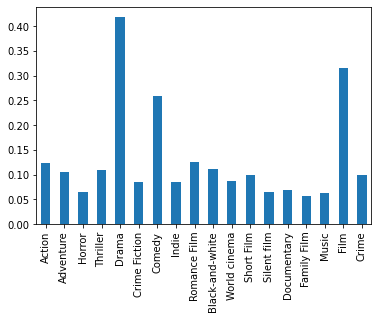

In [136]:
genre_presence_filtered = genre_presence[genre_presence >= genre_presence.quantile(0.95)]
genre_presence_filtered.plot.bar()
plt.show()

<h2>Languages</h2>

In [137]:
languages = movie_metadata.freebase_languages.unique()

print(f"Unique languages combinations: {len(languages)}")

Unique languages combinations: 1667


Again, should we analyze combinations or only presence of languages...? To account for 1667 combinations may be way too difficult for the analysis

In [138]:
# Search for languages
language_search = []
for language in languages:
    if language == "":
        continue ##Blank language
    
    sub_language = language.split(",")
    
    sub_language = [x for x in sub_language if x not in language_search]
    
    language_search += sub_language
    

print(f"Amount of language present in language combinations: {len(language_search)}")

Amount of language present in language combinations: 215


In [139]:
indicator_cols = []

for lang in language_search:
    indicator_cols.append(pd.DataFrame({lang: movie_metadata.freebase_languages.apply(lambda x: lang in x).values}))

indicator_cols = pd.concat(indicator_cols, axis = 1)
indicator_cols["movie_id"] = movie_metadata.index
indicator_cols = indicator_cols.set_index('movie_id')

<ipython-input-139-9deea60be47f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  indicator_cols["movie_id"] = movie_metadata.index


In [140]:
movie_metadata_indicator = pd.merge(movie_metadata, indicator_cols, left_index = True, right_index = True)
movie_metadata_indicator.head()

,movie_name,box_office_revenue,runtime,freebase_languages,freebase_countries,freebase_genres,English Language,Norwegian Language,German Language,Silent film,...,Hmong language,Osetin Language,Deutsch,Nahuatl languages,Hainanese,Chewa language,Haryanvi Language,Assyrian language,Papiamento language,Kuna language
movie_id,,,,,,,,,,,,,,,,,,,,,
975900,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Action,Adventure,Horror,Science Fiction,Space ...",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Biographical film,Crime Drama,Drama,Mystery",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28463795,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama",False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
9363483,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Erotic thriller,Psychological thriller,Thriller",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
261236,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [141]:
language_presence = movie_metadata_indicator[language_search].sum(axis = 0) / movie_metadata_indicator.shape[0]

In [142]:
language_presence.describe()

count    215.000000
mean       0.005082
std        0.034810
min        0.000012
25%        0.000024
50%        0.000122
75%        0.000960
max        0.500251
dtype: float64

Same as with genre

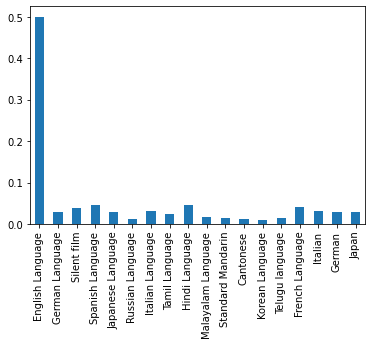

In [143]:
language_presence_filtered = language_presence[language_presence >= language_presence.quantile(0.92)]
language_presence_filtered.plot.bar()
plt.show()

<h2>Countries</h2>

In [144]:
movie_metadata.freebase_countries.describe()

count                        81741
unique                        2021
top       United States of America
freq                         30300
Name: freebase_countries, dtype: object

If we were to use the map idea, we would need to use a more interesting approach to reducing the number of countries. There are 2021 unique country values, so maybe we could cluster them in regions. Cluster.. as in literal clustering or using different criterion such as geographic regions or something we could observe from the data (``May involve manual exploration``).

In [145]:
len(movie_metadata.movie_name), len(movie_metadata.movie_name.unique())

(81741, 75478)

In [146]:
movie_metadata

,movie_name,box_office_revenue,runtime,freebase_languages,freebase_countries,freebase_genres
movie_id,,,,,,
975900,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Action,Adventure,Horror,Science Fiction,Space ..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Biographical film,Crime Drama,Drama,Mystery"
28463795,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama"
9363483,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Erotic thriller,Psychological thriller,Thriller"
261236,A Woman in Flames,NaN,106.0,German Language,Germany,Drama
...,...,...,...,...,...,...
35228177,Mermaids: The Body Found,NaN,120.0,English Language,United States of America,Drama
34980460,Knuckle,NaN,96.0,English Language,"Ireland,United Kingdom","Biographical film,Documentary,Drama"
9971909,Another Nice Mess,NaN,66.0,English Language,United States of America,"Comedy,Satire"


In [150]:
countries = movie_metadata.freebase_countries.unique()

In [151]:
countries_search = []
for country in countries:
    if country == "":
        continue ##Blank language
    
    sub_countries = country.split(",")
    
    sub_countries = [x for x in sub_countries if x not in countries_search]
    
    countries_search += sub_countries
    

print(f"Amount of countries in present countries combinations: {len(countries_search)}")

Amount of countries in present countries combinations: 147


In [154]:
countries_search

['United States of America',
 'Norway',
 'United Kingdom',
 'Germany',
 'South Africa',
 'Argentina',
 'Japan',
 'Turkey',
 'German Democratic Republic',
 'Soviet Union',
 'France',
 'Italy',
 'India',
 'New Zealand',
 'Mexico',
 'Australia',
 'Hong Kong',
 'Netherlands',
 'Denmark',
 'Sweden',
 'Canada',
 'Brazil',
 'Switzerland',
 'Poland',
 'Spain',
 'South Korea',
 'Hungary',
 'West Germany',
 'Pakistan',
 'Yugoslavia',
 'Algeria',
 'Nepal',
 'Kenya',
 'England',
 'Finland',
 'Ireland',
 'China',
 'Austria',
 'Philippines',
 'Romania',
 'Czech Republic',
 'Slovakia',
 'Portugal',
 'Egypt',
 'Czechoslovakia',
 'Northern Ireland',
 'Israel',
 'Iceland',
 'Indonesia',
 'Belgium',
 'Greece',
 'Iraq',
 'Republic of Macedonia',
 'Russia',
 'Taiwan',
 'Iran',
 'Lebanon',
 'Bosnia and Herzegovina',
 'Croatia',
 'Malaysia',
 'Uzbekistan',
 'Nazi Germany',
 'Weimar Republic',
 'Morocco',
 'Puerto Rico',
 'Luxembourg',
 'Tunisia',
 'Albania',
 'Cambodia',
 'Thailand',
 'Estonia',
 'Chile',
 '

In [159]:
movie_metadata[movie_metadata.freebase_countries.isin(["Nazi Germany"])]

,movie_name,box_office_revenue,runtime,freebase_languages,freebase_countries,freebase_genres
movie_id,,,,,,
1970651,Der ewige Jude,NaN,62.0,German Language,Nazi Germany,"Black-and-white,History,Propaganda film"
34002384,Friedrich Schiller - The Triumph of a Genius,NaN,98.0,German Language,Nazi Germany,Drama
26273295,Das Erbe,NaN,NaN,,Nazi Germany,Propaganda film
